### Preparar dataset


In [169]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

In [170]:
# Leer el archivo de texto
df = pd.read_csv('./Data/data.txt', sep=' ', header=None)
df.columns = ['ID', 'Background_tissue', 'Class', 'Severity', 'Abnormality_X', 'Abnormality_Y', 'Radius']

print(df)

         ID Background_tissue Class Severity Abnormality_X Abnormality_Y  \
0    mdb001                 G  CIRC        B           535           425   
1    mdb002                 G  CIRC        B           522           280   
2    mdb003                 D  NORM      NaN           NaN           NaN   
3    mdb004                 D  NORM      NaN           NaN           NaN   
4    mdb005                 F  CIRC        B           477           133   
..      ...               ...   ...      ...           ...           ...   
325  mdb318                 D  NORM      NaN           NaN           NaN   
326  mdb319                 D  NORM      NaN           NaN           NaN   
327  mdb320                 D  NORM      NaN           NaN           NaN   
328  mdb321                 D  NORM      NaN           NaN           NaN   
329  mdb322                 D  NORM      NaN           NaN           NaN   

     Radius  
0     197.0  
1      69.0  
2       NaN  
3       NaN  
4      30.0  
.. 

In [171]:
ruta_carpeta_principal = 'imgs'
# Lista para almacenar las rutas de las imágenes
rutas_imagenes_hr = []

# Recorrer todas las carpetas y archivos dentro de la carpeta principal
for directorio, subdirectorios, archivos in os.walk(ruta_carpeta_principal):
    for archivo in archivos:
        if archivo.endswith('_HR.png'):
            ruta_completa = os.path.join(directorio, archivo)
            rutas_imagenes_hr.append(ruta_completa)


df_imagenes_hr = pd.DataFrame({'ruta_imagen': rutas_imagenes_hr})
print(df_imagenes_hr)


                  ruta_imagen
0   imgs/mdb100/mdb100_HR.png
1   imgs/mdb044/mdb044_HR.png
2   imgs/mdb088/mdb088_HR.png
3   imgs/mdb043/mdb043_HR.png
4   imgs/mdb075/mdb075_HR.png
..                        ...
95  imgs/mdb009/mdb009_HR.png
96  imgs/mdb036/mdb036_HR.png
97  imgs/mdb031/mdb031_HR.png
98  imgs/mdb038/mdb038_HR.png
99  imgs/mdb007/mdb007_HR.png

[100 rows x 1 columns]


In [172]:
# Extraer el ID base del DataFrame de rutas
df_imagenes_hr['ID_base'] = df_imagenes_hr['ruta_imagen'].str.split('/').str[-1].str.replace('_HR.png', '')

# Realizar la fusión de los DataFrames
df_merged = pd.merge(df, df_imagenes_hr, left_on='ID', right_on='ID_base', how='left')

# Eliminar la columna auxiliar 'ID_base' si ya no la necesitas
df_merged.drop(columns=['ID_base'], inplace=True)

df_merged = df_merged.dropna(subset=['ruta_imagen'])

df_merged.to_csv('rutas_imagenes_hr.csv', index=False)


### Llenar valores vacíos y aplicar one hot encoding en columnas necesarias

In [173]:
df_merged[['Abnormality_X', 'Abnormality_Y', 'Radius']] = df_merged[['Abnormality_X', 'Abnormality_Y', 'Radius']].fillna(-1)


columnas_a_codificar = ['Background_tissue', 'Class', 'Severity']
df_encoded = pd.get_dummies(df_merged[columnas_a_codificar], prefix=columnas_a_codificar)

columnas_originales = [col for col in df_merged.columns if col not in columnas_a_codificar]

df_original_no_codificado = df_merged[columnas_originales]


df_merged = pd.concat([df_original_no_codificado, df_encoded], axis=1)


df_merged.to_csv('rutas_imagenes_hr.csv', index=False)

### Inicia modelo


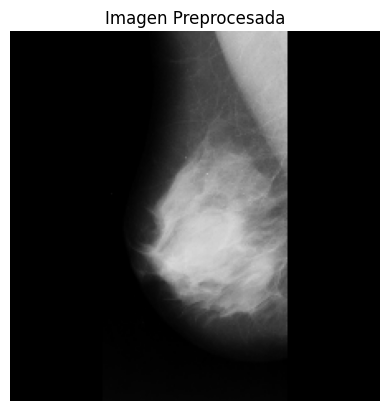

In [174]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
df= df_merged
# Definimos el tamaño de entrada para EfficientNet B0
IMG_SIZE = (224, 224)

def load_and_preprocess_image(img_path):
    """Carga y preprocesa una imagen."""
    # Cargar imagen
    img = cv2.imread(img_path)
    # Redimensionar
    img = cv2.resize(img, IMG_SIZE)
    # Convertir a float32 y normalizar
    img = img.astype('float32') / 255.0
    return img

# Probamos la función de carga con una imagen
sample_img_path = df['ruta_imagen'].iloc[0]
sample_img = load_and_preprocess_image(sample_img_path)

plt.imshow(sample_img)
plt.title("Imagen Preprocesada")
plt.axis("off")
plt.show()


In [175]:
from sklearn.model_selection import train_test_split
# Definir las etiquetas utilizando las clases de interés
labels = df[['Class_ASYM', 'Class_CIRC', 'Class_MISC', 'Class_NORM']].values

# Carga todas las imágenes y sus respectivas etiquetas
images = np.array([load_and_preprocess_image(img_path) for img_path in df['ruta_imagen']])

print(f"Forma de images: {images.shape}")  # Debe ser (n_samples, 224, 224, 3)
print(f"Forma de labels: {labels.shape}")  # Debe ser (n_samples, 4)


# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Verificamos las formas de los conjuntos
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Forma de images: (101, 224, 224, 3)
Forma de labels: (101, 4)
X_train shape: (80, 224, 224, 3), y_train shape: (80, 4)
X_test shape: (21, 224, 224, 3), y_test shape: (21, 4)


### Implementacion del modelo

In [176]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Número de clases (4 clases: ASYM, CIRC, MISC, NORM)
NUM_CLASSES = 4

# Cargar EfficientNet B0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Modelo secuencial
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),  # Capa oculta
    Dense(NUM_CLASSES, activation='softmax')  # Capa de salida con softmax
])

# Compilamos el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [177]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Configuramos callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_split=0.2, 
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3294 - loss: 1.2727

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step - accuracy: 0.3604 - loss: 1.2590 - val_accuracy: 0.7500 - val_loss: 0.8551
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6523 - loss: 1.0939

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.6562 - loss: 1.0793 - val_accuracy: 0.7500 - val_loss: 0.7249
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.6167 - loss: 1.1030 - val_accuracy: 0.7500 - val_loss: 0.7261
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.6625 - loss: 1.0359 - val_accuracy: 0.7500 - val_loss: 0.7546
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.6104 - loss: 1.1607 - val_accuracy: 0.7500 - val_loss: 0.7878
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.6458 - loss: 1.0110 - val_accuracy: 0.7500 - val_loss: 0.7806
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.6750 - loss: 1.0089 - val_accuracy: 0.7500 - val_loss: 0.7615


In [180]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print(f"Loss en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_acc:.4f}")


1/1 - 0s - 319ms/step - accuracy: 0.7143 - loss: 0.8994
Loss en test: 0.8994
Accuracy en test: 0.7143
